In [16]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

# Test cases

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
pd.options.mode.chained_assignment = None

path = "/home/raulsanchez/recsys_airbnb/"
city_labes = city_labels = ["NYC", "SFO", "LAX", "CHI", "BOS"]

test_cases = pd.read_csv(path+'datasets/test_cases_v1.7.csv', sep="\t", 
                         header=0, na_values="NaNxxxx", low_memory=False)
have_neightbors = test_cases[test_cases.valid_neighbor_users_length>0]
have_neightbors_and_airbnb_ranking = have_neightbors[have_neightbors.airbnb_ranking_length > 0]
experiment = have_neightbors_and_airbnb_ranking
print("Total Test Cases = "+str(len(experiment)))
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

Total Test Cases = 2495


Every test case is composed by:
* Target room 
* Target guest 
* Date
* Guest history (Training data)
* Rooms around target (to rank on experiment 1)
* Airbnb Ranking (rooms to rank on experiment 2)

## Target Rooms, Target Guests and Test Cases

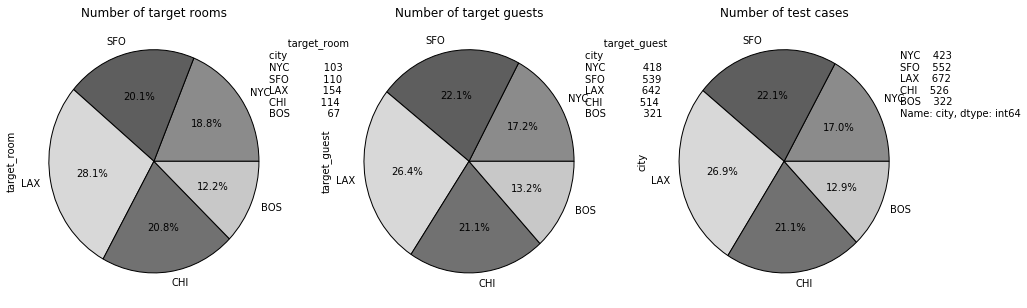

In [15]:
fig, axs = plt.subplots(1,3)

number_of_target_rooms_by_city = pd.DataFrame(experiment.groupby("city").target_room.unique().apply(len))
number_of_target_rooms_by_city.target_room.loc[city_labels].plot(kind="pie", 
    colormap=grayify_cmap("prism"), figsize=(6,5), autopct='%1.1f%%',
    title="Number of target rooms", ax=axs[0]).text(1.1,0.4,str(number_of_target_rooms_by_city.loc[city_labels]))

number_of_target_guests_by_city = pd.DataFrame(experiment.groupby("city").target_guest.unique().apply(len))
number_of_target_guests_by_city.target_guest.loc[city_labels].plot(kind="pie", 
    colormap=grayify_cmap("prism"), figsize=(6,5), autopct='%1.1f%%',
    title="Number of target guests", ax=axs[1]).text(1.1,0.4,str(number_of_target_guests_by_city.loc[city_labels]))

number_of_test_cases = experiment.city.value_counts().loc[city_labels]
number_of_test_cases.plot(kind="pie", 
    colormap=grayify_cmap("prism"), figsize=(6,5), autopct='%1.1f%%',
    title="Number of test cases",  ax=axs[2]).text(1.1,0.4, str(number_of_test_cases.loc[city_labels] ));

fig.set_size_inches(16, 5)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

* NYC, SFO and LAX datasets has some users that whet more than once to the respective city (did they go to the same rooms?)

* CHI and BOS has fewer target rooms than target guests: target_rooms << target_guests. This is just to tell that for almost all target rooms we have more than one target guest with it's respective history (which is desirable for collaborative filtering)

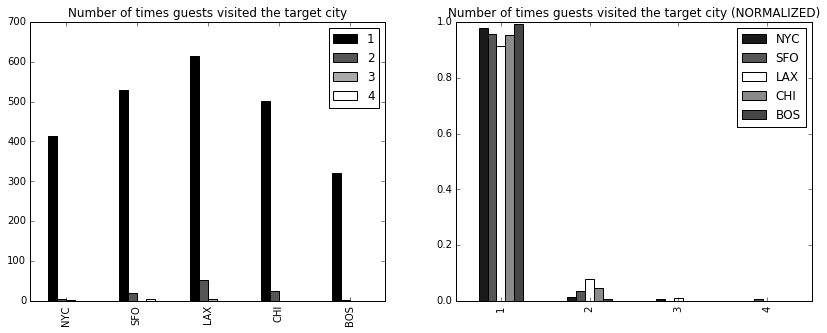

In [4]:
fig, axs = plt.subplots(1,2)

city = experiment[experiment.city == "NYC"]
count=list()
for i in range(0,len(city)):
    count.append(len(city[city.target_guest == city.target_guest.iloc[i]]))
number_visits_target_city = pd.DataFrame(count)[0].value_counts()

for c in city_labels[1:]:
    city_local = experiment[experiment.city == c]
    count=list()
    for i in range(0,len(city_local)):
        count.append(len(city_local[city_local.target_guest == city_local.target_guest.iloc[i]]))
    number_visits_target_city_local = pd.DataFrame(count)[0].value_counts()
    number_visits_target_city = pd.concat([number_visits_target_city, number_visits_target_city_local], axis=1)
number_visits_target_city.columns = city_labels

number_visits_target_city.T.plot(kind="bar",figsize=(8,10), colormap="gray",
                                 ax=axs[0], title="Number of times guests visited the target city");

number_visits_target_city = number_visits_target_city/ number_visits_target_city.sum()
number_visits_target_city.plot(kind="bar",figsize=(8,10), colormap=grayify_cmap("seismic"),
                               ax=axs[1], title="Number of times guests visited the target city (NORMALIZED)");
fig.set_size_inches(14, 5)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Target Guest's history

Distribution of number of rooms in target guests history (Target rooms not included)

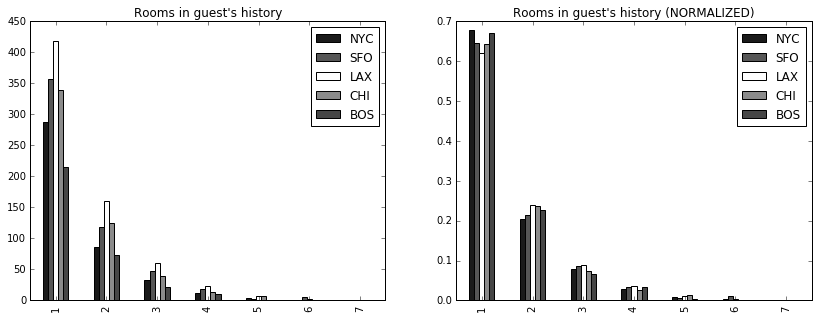

In [20]:
fig, axs = plt.subplots(1,2)

city = experiment[experiment.city=="NYC"]
rooms_in_history_by_city = city.target_guest_history_length.value_counts()
for c in city_labels[1:]:
    #c = city_labels[0]
    city = experiment[experiment.city==c]
    rooms_in_history_by_city_local = city.target_guest_history_length.value_counts()
    rooms_in_history_by_city= pd.concat([rooms_in_history_by_city, rooms_in_history_by_city_local], axis=1)

rooms_in_history_by_city.columns = city_labels
rooms_in_history_by_city.plot(kind="bar",figsize=(10,5), colormap=grayify_cmap("seismic"), ax=axs[0]
    , title="Rooms in guest's history");

rooms_in_history_by_city_normalized = rooms_in_history_by_city / rooms_in_history_by_city.sum()
rooms_in_history_by_city_normalized.plot(kind="bar",figsize=(10,5), colormap=grayify_cmap("seismic"), ax=axs[1]
    , title="Rooms in guest's history (NORMALIZED)");
fig.set_size_inches(14, 5)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Rooms around Target Room (1500 meters)

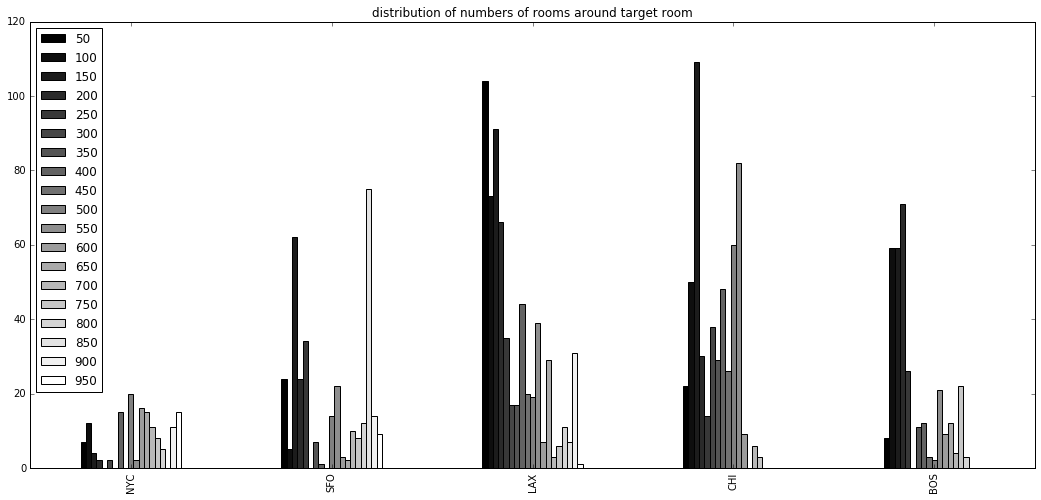

In [24]:
import numpy as np
city = experiment[experiment.city=="NYC"]
count, division = np.histogram(city.rooms_around_target_1500m_length,bins = range(0, 1000, 50))
rooms_around_target_by_city = pd.DataFrame(count)

for c in city_labels[1:]:
    #c = city_labels[0]
    city = experiment[experiment.city==c]
    count, division = np.histogram(city.rooms_around_target_1500m_length,bins = range(0, 1000, 50))
    rooms_around_target_by_city_local = pd.DataFrame(count)
    rooms_around_target_by_city = pd.concat([rooms_around_target_by_city, 
                                             rooms_around_target_by_city_local], axis=1)

rooms_around_target_by_city.columns = city_labels
rooms_around_target_by_city.index = division[1:]
rooms_around_target_by_city.T.plot(kind="bar",figsize=(18,8), colormap="gray", 
                                   title="distribution of numbers of rooms around target room");
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Rooms around Target Room (500 meters)

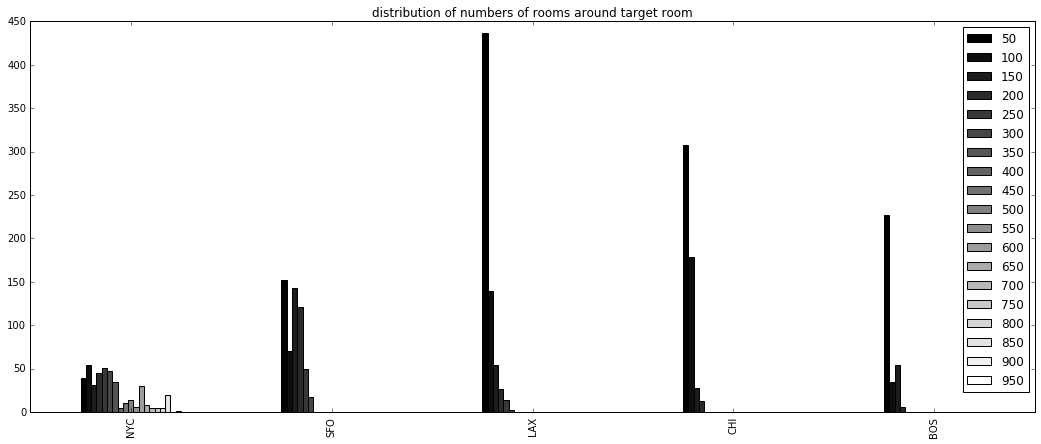

In [27]:
import numpy as np
city = experiment[experiment.city=="NYC"]
count, division = np.histogram(city.rooms_around_target_500m_length,bins = range(0, 1000, 50))
rooms_around_target_by_city = pd.DataFrame(count)
for c in city_labels[1:]:
    #c = city_labels[0]
    city = experiment[experiment.city==c]
    count, division = np.histogram(city.rooms_around_target_500m_length,bins = range(0, 1000, 50))
    rooms_around_target_by_city_local = pd.DataFrame(count)
    rooms_around_target_by_city = pd.concat([rooms_around_target_by_city, rooms_around_target_by_city_local], axis=1)

rooms_around_target_by_city.columns = city_labels
rooms_around_target_by_city.index = division[1:]
rooms_around_target_by_city.T.plot(kind="bar",figsize=(18,7), colormap="gray"
    , title="distribution of numbers of rooms around target room");
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Airbnb's rooms around target

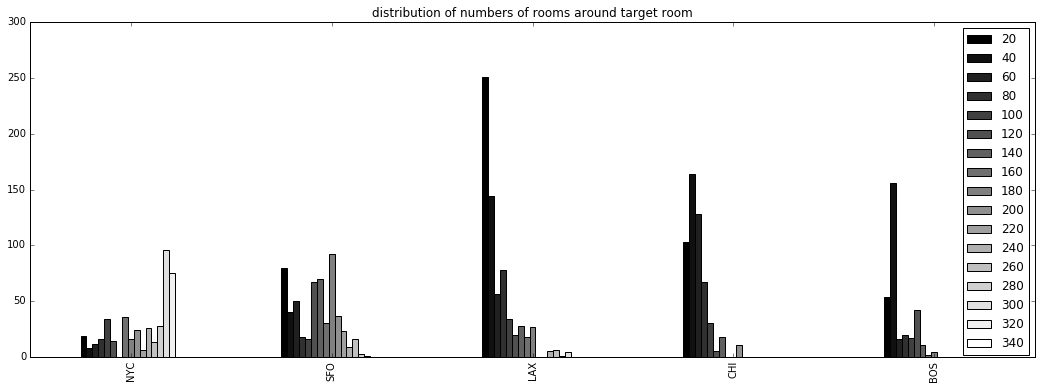

In [34]:
import numpy as np
city = experiment[experiment.city=="NYC"]
count, division = np.histogram(city.airbnb_ranking_length,bins = range(0, 350, 20))
rooms_around_target_by_city = pd.DataFrame(count)

for c in city_labels[1:]:
    #c = city_labels[0]
    city = experiment[experiment.city==c]
    count, division = np.histogram(city.airbnb_ranking_length,bins = range(0, 350, 20))
    rooms_around_target_by_city_local = pd.DataFrame(count)
    rooms_around_target_by_city = pd.concat([rooms_around_target_by_city, rooms_around_target_by_city_local], axis=1)

rooms_around_target_by_city.columns = city_labels
rooms_around_target_by_city.index = division[1:]
rooms_around_target_by_city.T.plot(kind="bar",figsize=(18,6), colormap="gray"
    , title="distribution of numbers of rooms around target room");
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Number of Neighbor users
Neighbor users are users that share a common item in their history that would be exploited on Collaborative Filtering

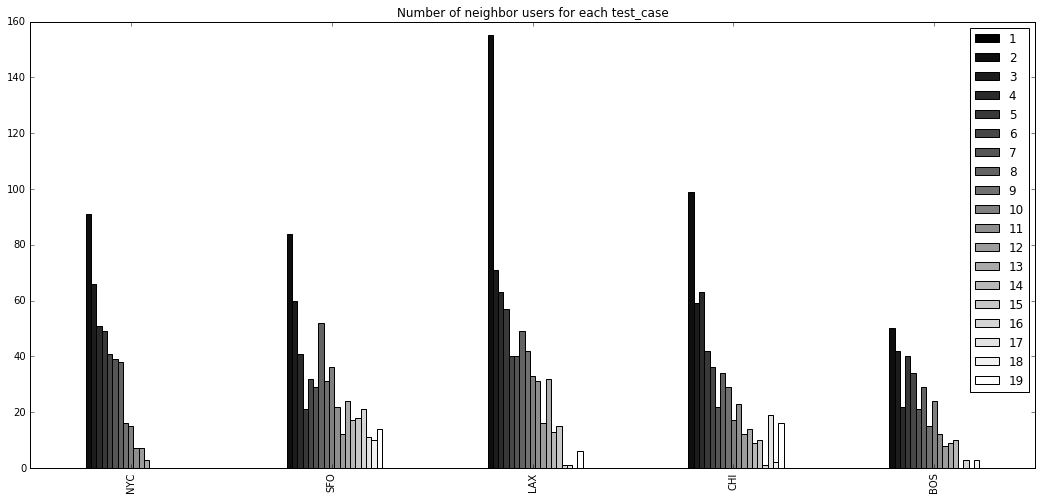

In [35]:
import numpy as np
city = experiment[experiment.city=="NYC"]
count, division = np.histogram(city.valid_neighbor_users_length,bins = range(0, 20, 1))
number_of_valid_neighbor_users = pd.DataFrame(count)
#test_casesvalid_neighbor_users_history_mean
for c in city_labels[1:]:
    #c = city_labels[0]
    city = experiment[experiment.city==c]
    count, division = np.histogram(city.valid_neighbor_users_length,bins = range(0, 20, 1))
    number_of_valid_neighbor_users_local = pd.DataFrame(count)
    number_of_valid_neighbor_users = pd.concat([number_of_valid_neighbor_users, 
                                                number_of_valid_neighbor_users_local], axis=1)

number_of_valid_neighbor_users.columns = city_labels
number_of_valid_neighbor_users.index = division[1:]
number_of_valid_neighbor_users.T.plot(kind="bar",figsize=(18,8), colormap="gray"
    , title="Number of neighbor users for each test_case");
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

From previous plot we saw that

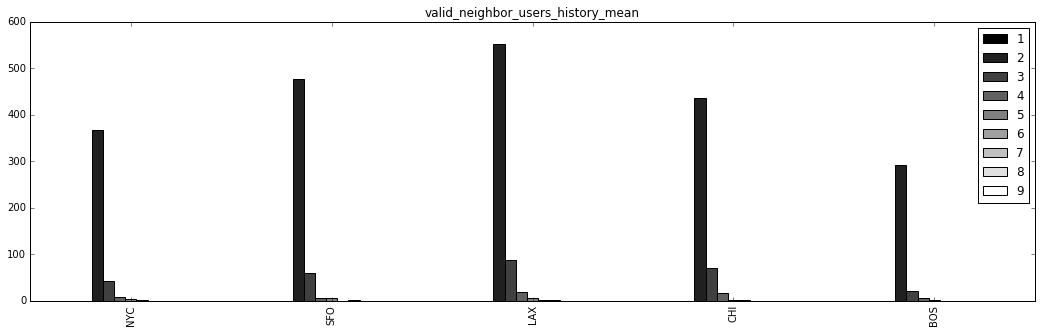

In [36]:
import numpy as np
city = experiment[experiment.city=="NYC"]
count, division = np.histogram(city.valid_neighbor_users_history_mean,bins = range(0, 10, 1))
valid_neighbor_users_history_mean = pd.DataFrame(count)

for c in city_labels[1:]:
    #c = city_labels[0]
    city = experiment[experiment.city==c]
    count, division = np.histogram(city.valid_neighbor_users_history_mean,bins = range(0, 10, 1))
    valid_neighbor_users_history_mean_local = pd.DataFrame(count)
    valid_neighbor_users_history_mean = pd.concat([valid_neighbor_users_history_mean, 
                                                valid_neighbor_users_history_mean_local], axis=1)

valid_neighbor_users_history_mean.columns = city_labels
valid_neighbor_users_history_mean.index = division[1:]
valid_neighbor_users_history_mean.T.plot(kind="bar",figsize=(18,5), colormap="gray"
    , title="valid_neighbor_users_history_mean");
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

# Similarity between experiment 1 and experiment 2

On both experiments, we have a list of rooms to rank. The difference betwee each list, is that one set of rooms is drawn from:
- rooms contained in **InsideAirbnb's dataset** that are around 500 meters from the target room.
- rooms contained in **Airbnb's Non Personalized Rank** around 500 meters from the target room.

This set of rooms in eaither experiment we would refer as **rooms_around_target_room**
## **rooms_around_target_room** from experiment 1 and 2
Number of rooms around target room (500 meters)
- X-axis experiment 1
- Y-axis experiment 2

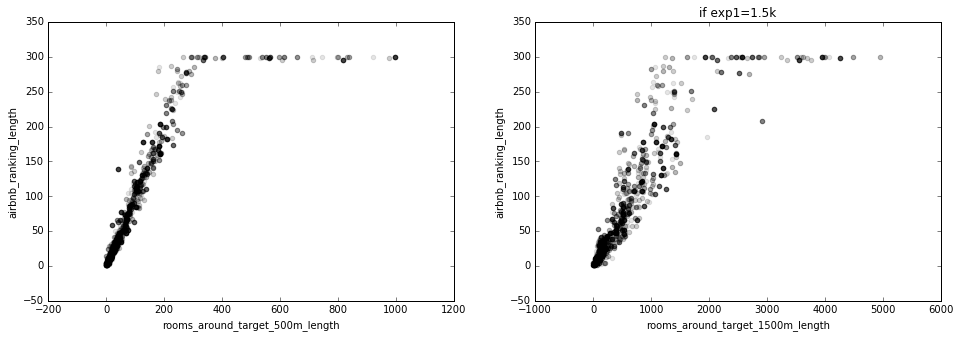

In [46]:
fig, axs = plt.subplots(1,2)

have_neightbors_and_airbnb_ranking.plot(kind='scatter', x="rooms_around_target_500m_length",
                                        y="airbnb_ranking_length", alpha=0.1, color="k", ax=axs[0]);
have_neightbors_and_airbnb_ranking.plot(kind='scatter',x="rooms_around_target_1500m_length",title="if exp1=1.5k",
                                        y="airbnb_ranking_length", alpha=0.1, color="k", ax=axs[1]);
fig.set_size_inches(16, 5)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')

## Proportion of rooms_around_target presented on each experiment

Scatter plot (alpha=0.1).

Proportion of rooms presented from one set of rooms_around_target from experiment_1 within experiment_2 and viceversa, (The size of the point is a coeffitien proportional to the rooms_aroun_target list size).

In [31]:
have_neightbors_and_airbnb_ranking["rooms_exp1_within_exp2"] = [0]*len(have_neightbors_and_airbnb_ranking)
have_neightbors_and_airbnb_ranking["rooms_exp2_within_exp1"] = [0]*len(have_neightbors_and_airbnb_ranking)
have_neightbors_and_airbnb_ranking["rooms_exp1_2_within_exp2"] = [0]*len(have_neightbors_and_airbnb_ranking)
have_neightbors_and_airbnb_ranking["rooms_exp2_within_exp1_2"] = [0]*len(have_neightbors_and_airbnb_ranking)

for index, test_case in have_neightbors_and_airbnb_ranking.iterrows():
    #test_case= test_cases.iloc[0]
    exp1 = set(test_case.rooms_around_target_500m)
    exp2 = set(test_case.airbnb_ranking)
    exp1_2 = set(test_case.rooms_around_target_1500m)
    
    test_case.rooms_exp1_within_exp2 = len(list(exp1.intersection(exp2)))/len(test_case.rooms_around_target_500m)
    test_case.rooms_exp2_within_exp1 = len(list(exp2.intersection(exp1)))/len(test_case.airbnb_ranking)
    
    test_case.rooms_exp1_2_within_exp2 = len(list(exp1_2.intersection(exp2)))/len(test_case.rooms_around_target_1500m)
    test_case.rooms_exp2_within_exp1_2 = len(list(exp2.intersection(exp1_2)))/len(test_case.airbnb_ranking)
    
    have_neightbors_and_airbnb_ranking.loc[index]=test_case

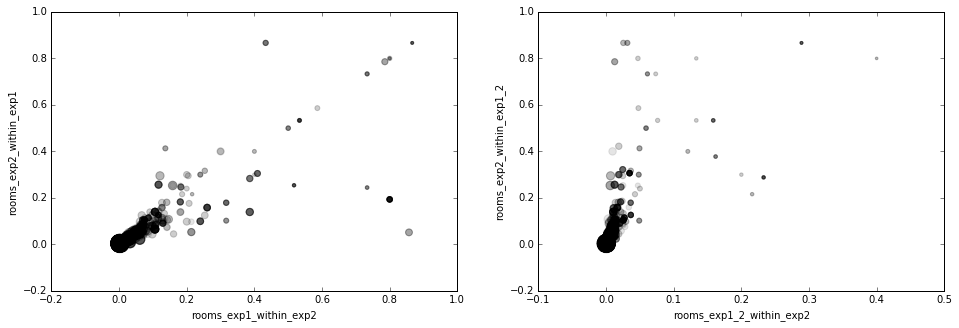

In [60]:
fig, axs = plt.subplots(1,2)
data = have_neightbors_and_airbnb_ranking
data.plot(kind='scatter', x="rooms_exp1_within_exp2",y="rooms_exp2_within_exp1", 
          s=np.sqrt(data.rooms_around_target_1500m_length)*5, 
          alpha=0.1, ax=axs[0], color="k");

data.plot(kind='scatter', x="rooms_exp1_2_within_exp2",y="rooms_exp2_within_exp1_2",
          s=np.sqrt(data.rooms_around_target_1500m_length)*5,
          alpha=0.1, ax=axs[1], color="k");
fig.set_size_inches(16, 5)
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="View code"></form>''')